## Shortest path relation extraction with word embeddings
Approach:
* Locate Named Entities in the sentece
* Extract dependency path of the sentence using the spaCy dependy parser
* Build an undirected network graph of the dependencies in the sentece
* Search for the shortest path between every two entities and assume them as related to be each other
* Computer feature vector (word embedding) for shortest path feature
* Cluster the entities depending on features

In [1]:
import enum
import networkx as nx
import spacy
import matplotlib.pyplot as plt
import logging
import pandas as pd
import numpy as np
import re

from networkx.exception import NodeNotFound, NetworkXNoPath
from gensim.models import KeyedVectors
from nltk.tokenize import sent_tokenize, word_tokenize

nlp = spacy.load('de')
model = KeyedVectors.load_word2vec_format('../models/german.model', binary=True)

c:\program files\python\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
relationship_list = ['vater', 'mutter', 'sohn', 'tochter', 'bruder', 'schwester', 'enkel', 'enkelin', 'nichte',
                     'neffe', 'onkel', 'tante']
me_list = ['ich', 'meine', 'mein', 'meiner', 'meinem', 'meinen']

In [3]:
#text = u'''Herbert ist der Vater von Hans'''
#text = u'''Peter und Maria gehen morgen ins Kino'''
#text = u'''Herbert sein Sohn und ich gehen heute ins Kino'''
# text = u'''Ich gehe mit Johann in den Zoo'''
#text = u'''Hans und sein Sohn Hubert gehen in den Zoo.'''
text = u'''Hans, welcher der Sohn von Hubert ist, geht mit Peter ins Kino.'''
#text = u'''Meine kleine Enkelin Lisa und mein Enkel Lukas fliegen morgen nach London.'''
#text = u'''Ich fahre mit meinen Enkeln Lukas und Lisa in den Urlaub.'''
#text = u'''Potesters seized several pumping stations, holding 127 Shell workers hostage.'''
#text = u'''Troops recently have raided churches, warning ministers to stop preaching.'''

## Named Entity Recognition

### spaCy NER

In [4]:
doc = nlp(text)

In [10]:
entities = []
for ent in doc.ents:
    if ent.label_ == 'PER':
        entities.append(ent.text.lower())

for token in doc:
    if token.text.lower() in me_list:
        entities.append(token.text.lower())

entities

['hans', 'sohn', 'hubert', 'peter']

### Flair NER

In [11]:
from flair.data import Sentence
from flair.models import SequenceTagger

entities = []

text = re.sub('\W+', ' ', text) # remove non-word characters
sentence = Sentence(text)
tagger = SequenceTagger.load('de-ner')
tagger.predict(sentence) # run NER over sentence

for entity in sentence.get_spans('ner'):
    print(entity)
    if entity.tag == 'PER':
        entities.append(entity.text.lower())

#for token in sentence:
#    ner_tag = token.get_tag('ner')
#    print(f'{token}, {ner_tag}')
        
entities

PER-span [1]: "Hans"
PER-span [6]: "Hubert"
PER-span [10]: "Peter"


['hans', 'hubert', 'peter']

## Build undirected graph

In [12]:
for sentence in sent_tokenize(text):
    doc = nlp(sentence)
    edges = []
    for token in doc:
        for child in token.children:
            edges.append((f'{token.lower_}',
                          f'{child.lower_}'))
    graph = nx.Graph(edges)

c:\program files\python\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


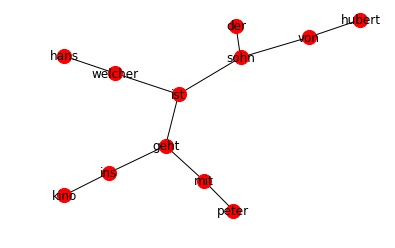

In [13]:
# nx.draw_networkx(graph, node_size=100, ode_color=range(len(graph)))
pos = nx.spring_layout(graph)  # positions for all nodes
# nodes
nx.draw_networkx_nodes(graph, pos, node_size=200)
# edges
nx.draw_networkx_edges(graph, pos, width=1)
# labels
nx.draw_networkx_labels(graph, pos, font_size=12, font_family='sans-serif')

plt.axis('off')  # disable axis
plt.show()

## Shortest Path
Find shortest path between every found two entities

In [17]:
path_dict = {}
for i, first_entity in enumerate(entities):
    for j in range(len(entities)):
    #for j in range(i+1, len(entities)):
        second_entity = entities[j]
        if not i == j and second_entity not in me_list:        
            try:
                shortest_path = nx.shortest_path(graph, source=first_entity, target=second_entity)
                key = first_entity + '-' + second_entity
                path_dict[key] = shortest_path
            except NodeNotFound as err:
                logging.warning(f'Node not found: {err}')
            except NetworkXNoPath as err:
                logging.warning(f'No path found: {err}')

path_dict

{'hans-hubert': ['hans', 'welcher', 'ist', 'sohn', 'von', 'hubert'],
 'hans-peter': ['hans', 'welcher', 'ist', 'geht', 'mit', 'peter'],
 'hubert-hans': ['hubert', 'von', 'sohn', 'ist', 'welcher', 'hans'],
 'hubert-peter': ['hubert', 'von', 'sohn', 'ist', 'geht', 'mit', 'peter'],
 'peter-hans': ['peter', 'mit', 'geht', 'ist', 'welcher', 'hans'],
 'peter-hubert': ['peter', 'mit', 'geht', 'ist', 'sohn', 'von', 'hubert']}

## Feature Extraction

In [18]:
feature_columns = ['m1', 'm2', 'm1_pos', 'm2_pos', 'before_m1', 'after_m2', 'between_words', 
                   'short_path', 'm1_head', 'm2_head']

features = pd.DataFrame(columns=feature_columns)

In [20]:
features_list = []  # for TF-IDF vectorization
#ners = []

# check for named entity 'PER' or 'PME' in each sentence
#for ner_tuple in ner_tuples:
#    if 'I-PER' in ner_tuple:
#        ners.append(ner_tuple)
#    elif ner_tuple[0].lower() in me_list:
#        ners.append((ner_tuple[0], 'PME'))
#    elif ner_tuple[0].lower() in relationship_list:
#        ners.append((ner_tuple[0], 'SOC'))

for sentence in sent_tokenize(text):
    sentence = re.sub(r'\W+', ' ', sentence.lower()) # remove non-word characters
    print(sentence)
    doc = nlp(sentence)
    
    for key, value in path_dict.items():
        # extract entities
        m1 = key.split('-')[0]
        m2 = key.split('-')[1]

        short_path = value

        # POS tagging and head
        for token in doc:
            if token.text.lower() == m1:
                m1_pos_tag = token.pos_
                m1_head = token.head.text
                #m1_children = [child for child in token.children]
            elif token.text.lower() == m2:
                m2_pos_tag = token.pos_
                m2_head = token.head.text
                #m2_children = [child for child in token.children]

        # Dependecy parsing
        #dep_path = []
        #for chunk in doc.noun_chunks:
        #    if chunk.root.text.lower() == m1 or chunk.root.text.lower() == m2:
        #        dep_path.append([chunk.root.text, chunk.root.dep_, chunk.root.head.text])  

        # Between words
        start_position_m1 = sentence.find(m1)
        start_position_m2 = sentence.find(m2)

        # verify if the words were found in the sentence
        if not start_position_m1 == -1 and not start_position_m2 == -1:
            start_position_between = start_position_m1 + len(m1) + 1
            end_position_between = start_position_m2

            between = sentence[start_position_between:end_position_between]
            between_words = []
            for word in word_tokenize(between):
                between_words.append(word)

            beforeM1 = sentence[:start_position_m1 - 1]
            afterM2 = sentence[start_position_m2 + len(m2):]

            beforeM1_list = word_tokenize(beforeM1)
            afterM2_list = word_tokenize(afterM2)

            data = {'m1': m1, 'm2': m2, 'm1_pos': m1_pos_tag, 'm2_pos': m2_pos_tag,
                    'before_m1': beforeM1_list, 'after_m2': afterM2_list,
                    'between_words': between_words, 'short_path': short_path,
                     'm1_head': m1_head, 'm2_head': m2_head}

            training_example = pd.Series(data, index=feature_columns)
            features = features.append(training_example, ignore_index=True)
            #context = [beforeM1, between, afterM2]
            #features_list.append(context)

#features_list

hans welcher der sohn von hubert ist geht mit peter ins kino


In [21]:
features.head()

,m1,m2,m1_pos,m2_pos,before_m1,after_m2,between_words,short_path,m1_head,m2_head
0,hans,hubert,VERB,VERB,"[hans, welcher, der, sohn, von, hubert, ist, g...","[ist, geht, mit, peter, ins, kino]","[welcher, der, sohn, von]","[hans, welcher, ist, sohn, von, hubert]",ist,von
1,hans,peter,VERB,ADJ,"[hans, welcher, der, sohn, von, hubert, ist, g...","[ins, kino]","[welcher, der, sohn, von, hubert, ist, geht, mit]","[hans, welcher, ist, geht, mit, peter]",ist,mit
2,hubert,hans,VERB,VERB,"[hans, welcher, der, sohn, von]","[welcher, der, sohn, von, hubert, ist, geht, m...",[],"[hubert, von, sohn, ist, welcher, hans]",von,ist
3,hubert,peter,VERB,ADJ,"[hans, welcher, der, sohn, von]","[ins, kino]","[ist, geht, mit]","[hubert, von, sohn, ist, geht, mit, peter]",von,mit
4,peter,hans,ADJ,VERB,"[hans, welcher, der, sohn, von, hubert, ist, g...","[welcher, der, sohn, von, hubert, ist, geht, m...",[],"[peter, mit, geht, ist, welcher, hans]",mit,ist


In [22]:
vector_feature_columns = ['m1', 'm2', 'short_path_vector']
vector_features = pd.DataFrame(columns=vector_feature_columns)

## Get Word Embeddings of the words inside the shortest path and sum them into a single vector
* Two Representations: GermanWordEmbeddings and Flair Word Embeddings

### GermanWordEmbeddings https://github.com/devmount/GermanWordEmbeddings

In [23]:
embedding_vectors = []
# get vector length
vector_len = len(model.wv['hallo'])

for row in features.iterrows():
    m1 = row[1]['m1']
    m2 = row[1]['m2']
    short_path = row[1]['short_path']
    
    # get the word embedding representation for each word in the shortest path
    #row_embeddings = np.empty(len(short_path))
    row_embeddings = []
    
    for word in short_path:
        try:
            row_embeddings.append(model.wv[word])
        except KeyError as err:
            print(err)
            row_embeddings.append(np.zeros(vector_len))
    
    #print(sum(row_embeddings))
    embedding_vectors.append(sum(row_embeddings))
    vector_data = {'m1': m1, 'm2': m2, 'short_path_embedding_vector': sum(row_embeddings)}
    training_example = pd.Series(vector_data, index=vector_feature_columns)
    vector_features = vector_features.append(training_example, ignore_index=True)

# summarize vectors    
#row_embeddings.sum()
vector_features


c:\program files\python\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until
c:\program files\python\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  app.launch_new_instance()


"word 'welcher' not in vocabulary"
"word 'ist' not in vocabulary"
"word 'sohn' not in vocabulary"
"word 'von' not in vocabulary"
"word 'hubert' not in vocabulary"
"word 'welcher' not in vocabulary"
"word 'ist' not in vocabulary"
"word 'mit' not in vocabulary"
"word 'hubert' not in vocabulary"
"word 'von' not in vocabulary"
"word 'sohn' not in vocabulary"
"word 'ist' not in vocabulary"
"word 'welcher' not in vocabulary"
"word 'hubert' not in vocabulary"
"word 'von' not in vocabulary"
"word 'sohn' not in vocabulary"
"word 'ist' not in vocabulary"
"word 'mit' not in vocabulary"
"word 'mit' not in vocabulary"
"word 'ist' not in vocabulary"
"word 'welcher' not in vocabulary"
"word 'mit' not in vocabulary"
"word 'ist' not in vocabulary"
"word 'sohn' not in vocabulary"
"word 'von' not in vocabulary"
"word 'hubert' not in vocabulary"
"word 'welcher' not in vocabulary"
"word 'ist' not in vocabulary"
"word 'sohn' not in vocabulary"
"word 'von' not in vocabulary"
"word 'hubert' not in vocabulary"

,m1,m2,short_path_vector
0,hans,hubert,NaN
1,hans,peter,NaN
2,hubert,hans,NaN
3,hubert,peter,NaN
4,peter,hans,NaN
5,peter,hubert,NaN
6,hans,hubert,NaN
7,hans,peter,NaN
8,hubert,hans,NaN
9,hubert,peter,NaN


### Flair Word Embeddings  https://github.com/zalandoresearch/flair

In [24]:
from flair.data import Sentence, Token
from flair.embeddings import WordEmbeddings

flair_embeddings = {}
for sentence in sent_tokenize(text):
    sentence = re.sub(r'\W', ' ', sentence)
    sentence = re.sub(r'\s{2,}', ' ', sentence)    
    
    sentence = Sentence(sentence.lower())
    glove_embedding = WordEmbeddings('de')
    #glove_embedding = WordEmbeddings('de-crawl')
    glove_embedding.embed(sentence)
    
    for token in sentence:
        flair_embeddings[token.text] = token.embedding


In [25]:
flair_embedding_vectors = []

for row in features.iterrows():
    m1 = row[1]['m1']
    m2 = row[1]['m2']
    short_path = row[1]['short_path']
    
    # get the word embedding representation for each word in the shortest path
    row_embeddings = []
    
    for word in short_path:
        try:
            row_embeddings.append(flair_embeddings[word])
        except KeyError as err:
            print(err)
            row_embeddings.append(np.zeros(vector_len))
    
    flair_embedding_vectors.append(sum(row_embeddings))
    vector_data = {'m1': m1, 'm2': m2, 'short_path_embedding_vector': sum(row_embeddings)}
    training_example = pd.Series(vector_data, index=vector_feature_columns)
    vector_features = vector_features.append(training_example, ignore_index=True)

#flair_embedding_vectors

## Create tuples of the word embedding vectors for plotting purposes

In [29]:
tuples = ()
for vector in flair_embedding_vectors:
    if not tuples:
        tuples = (vector, )
    else:
        tuples = tuples + (vector, )
        
tuples

(tensor([-1.0138e+00,  1.1764e+00, -1.6339e+00, -1.1766e+00,  4.2612e-01,
          1.9241e+00, -1.1474e+00, -3.6587e-01, -2.3549e-01,  1.2445e+00,
         -5.0199e-01,  1.1830e-01, -3.5968e-01, -5.2521e-01, -7.6272e-02,
         -2.5141e-01, -7.6722e-01,  1.5038e+00, -5.2591e-01,  7.6623e-01,
          9.2494e-01,  5.3450e-01,  7.5502e-01,  1.1793e+00,  4.3391e-01,
         -1.7278e-01, -9.2505e-01,  1.0305e+00, -6.8257e-01, -9.6356e-01,
          6.4891e-01,  1.4487e+00,  3.6396e-02, -4.1501e-02, -8.4409e-01,
         -1.7067e+00, -1.2033e+00,  2.1496e-01, -2.0985e-01,  1.0850e+00,
         -2.3613e-01,  5.4492e-02, -6.3588e-01,  1.5840e+00,  7.8437e-01,
         -6.1933e-01,  7.0842e-01, -2.0396e-01,  3.8305e-01, -1.0347e-02,
         -3.6630e-01, -2.3211e-01,  3.6085e-03,  6.9689e-01, -1.7182e-01,
         -1.2825e+00, -7.6323e-01, -4.4601e-01,  2.7214e-01,  8.8305e-01,
         -1.9206e+00,  2.0641e-01,  9.1704e-01, -3.1142e-01, -1.6386e+00,
         -6.8178e-01,  6.2883e-01,  7.

## Plot vectors

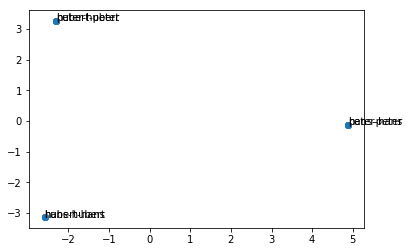

In [27]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X = np.vstack(tuples)
pca = PCA(n_components=2)
result = pca.fit_transform(X)

plt.scatter(result[:, 0], result[:, 1])
words = list(path_dict.keys())
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

## Clustering

#### Agglomerative (Hierarchical) clustering

In [69]:
from sklearn.cluster import AgglomerativeClustering

labels = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8])
agglo_clustering = AgglomerativeClustering(linkage='ward', n_clusters=3)
agglo_clustering.fit(X, labels)

agglo_clustering.labels_

array([2, 1, 2, 0, 1, 0, 2, 1, 2, 0, 1, 0], dtype=int64)

In [70]:
agglo_clustering.fit_predict(np.vstack(tuples[0]))

array([1, 0, 1, 1, 0, 0, 1, 2, 2, 0, 1, 0, 2, 1, 2, 2, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 2, 1, 0, 1, 1, 0, 0, 2, 2, 1, 1, 1, 0, 2, 0, 2, 2, 1, 0,
       0, 1, 0, 2, 0, 2, 2, 2, 2, 0, 2, 1, 1, 1, 0, 0, 1, 0, 0, 2, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 2, 1, 0, 2, 0, 1, 0, 0,
       1, 1, 2, 0, 1, 1, 0, 1, 0, 0, 1, 2, 0, 0, 2, 0, 0, 0, 1, 0, 2, 2,
       1, 0, 1, 1, 2, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 2, 0, 2, 1, 0, 1, 2, 2, 0, 0, 0, 1, 2, 1, 0, 0, 0, 1, 2, 0,
       2, 2, 1, 0, 0, 0, 2, 2, 1, 0, 1, 0, 1, 2, 1, 0, 1, 1, 0, 0, 2, 2,
       0, 0, 0, 2, 0, 0, 1, 2, 1, 0, 0, 2, 1, 0, 2, 1, 1, 2, 0, 1, 2, 2,
       1, 1, 1, 0, 0, 0, 0, 2, 1, 1, 2, 1, 0, 2, 0, 0, 1, 0, 2, 2, 0, 0,
       2, 0, 2, 0, 1, 2, 0, 0, 1, 2, 0, 2, 2, 0, 2, 1, 0, 1, 2, 1, 1, 0,
       1, 2, 2, 1, 1, 2, 1, 0, 1, 0, 2, 2, 0, 1, 0, 1, 1, 2, 2, 1, 0, 0,
       0, 0, 2, 2, 0, 1, 2, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 2, 2, 0, 1,
       1, 2, 1, 0, 2, 2, 2, 0, 1, 1, 2, 2, 0, 0], d

In [77]:
# Visualize the clustering
def plot_clustering(X_red, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(6, 4))
    #for i in range(X_red.shape[0]):
        #plt.text(X_red[i, 0], X_red[i, 1], str(y[i]),
        #         color=plt.cm.nipy_spectral(labels[i] / 10.),
        #         fontdict={'weight': 'bold', 'size': 9})

    
    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])


[-1.0137750e+00  1.1764390e+00 -1.6339041e+00 -1.1765680e+00
  4.2611620e-01  1.9241471e+00 -1.1474175e+00 -3.6586899e-01
 -2.3548520e-01  1.2444510e+00 -5.0199103e-01  1.1830300e-01
 -3.5967702e-01 -5.2520597e-01 -7.6271996e-02 -2.5140733e-01
 -7.6722133e-01  1.5038379e+00 -5.2590901e-01  7.6623303e-01
  9.2494476e-01  5.3449899e-01  7.5502098e-01  1.1792974e+00
  4.3390998e-01 -1.7277899e-01 -9.2505097e-01  1.0304580e+00
 -6.8256927e-01 -9.6355599e-01  6.4890897e-01  1.4487190e+00
  3.6396027e-02 -4.1500889e-02 -8.4408903e-01 -1.7066810e+00
 -1.2033070e+00  2.1496001e-01 -2.0984751e-01  1.0850461e+00
 -2.3612940e-01  5.4492056e-02 -6.3588399e-01  1.5839950e+00
  7.8437304e-01 -6.1932701e-01  7.0842487e-01 -2.0396200e-01
  3.8304904e-01 -1.0346979e-02 -3.6630198e-01 -2.3211101e-01
  3.6084950e-03  6.9688815e-01 -1.7182398e-01 -1.2824553e+00
 -7.6323152e-01 -4.4600999e-01  2.7214402e-01  8.8304603e-01
 -1.9206328e+00  2.0640901e-01  9.1704500e-01 -3.1141999e-01
 -1.6385598e+00 -6.81779

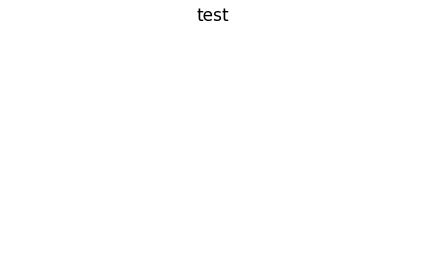

In [76]:
y = labels
plot_clustering(X, labels, title='test')